In [1]:
from scripts.utils import *
from scripts.new_model import *
import matplotlib.pyplot as plt

In [2]:
with open('data/schizo_genes_filtered.txt', 'r') as file:
    schizo_genes = [line.strip() for line in file]

In [3]:
with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
    embedding_dict = pickle.load(f)

In [4]:
from sklearn.decomposition import PCA
import numpy as np

# Convert embeddings to a numpy array
embeddings_matrix = np.array([embedding_dict[gene] for gene in schizo_genes if gene in embedding_dict])

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(embeddings_matrix)

# Print or visualize the results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)


Explained variance ratio: [0.04842688 0.03937585]
Principal components shape: (324, 2)


In [5]:
embeddings_matrix.shape

(324, 1536)

Variance explained by each component: [0.04842688 0.03937585]


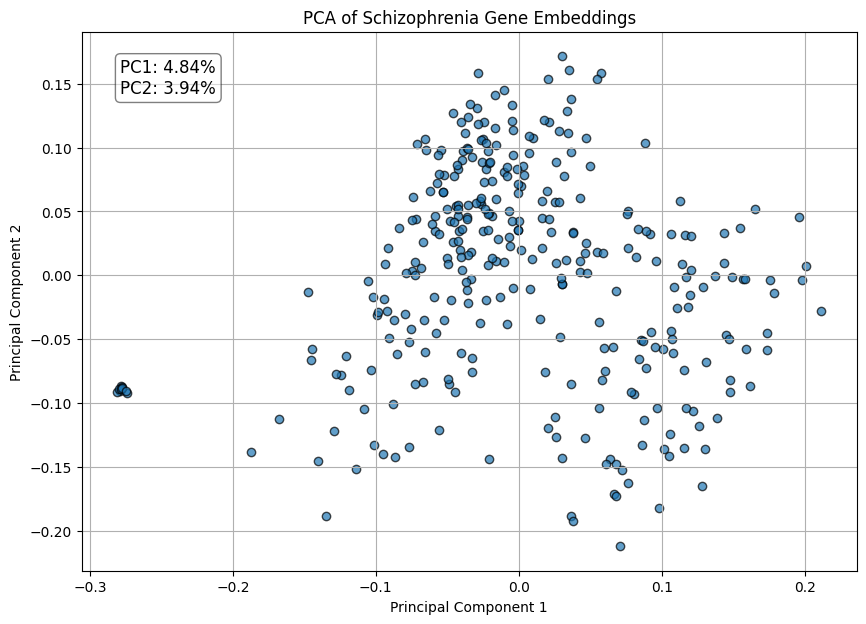

In [6]:
# Print the variance each principal component explains
print("Variance explained by each component:", pca.explained_variance_ratio_)

# Annotate the variance explained on the graph
variance_explained = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 7))
plt.text(0.05, 0.95, f"PC1: {variance_explained[0]:.2f}%\nPC2: {variance_explained[1]:.2f}%", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA of Schizophrenia Gene Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Evaluate MLP

In [7]:
model = torch.load('models/mlp_epistasis_new_tuned_model_full.pt', weights_only=False)
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [35]:
from itertools import combinations
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

def PCA_Distance_vs_prediction(genes, model, embedding_dict):
    filtered_genes = [gene for gene in genes if gene in embedding_dict]
    embeddings_matrix = np.array([embedding_dict[gene] for gene in filtered_genes])
    pca = PCA(n_components=2)  # Reduce to 2 principal components
    principal_components = pca.fit_transform(embeddings_matrix)

    distances = []
    prediction_scores = []
    gene_pairs = []

    device = torch.device("cpu")
    model.to(device)    

    # Iterate over all combinations of gene pairs
    for gene1, gene2 in combinations(filtered_genes, 2):
        if gene1 in embedding_dict and gene2 in embedding_dict:
            if gene1 != gene2:
                # Get the PCA coordinates of the two genes
                gene1_pca = principal_components[filtered_genes.index(gene1)]
                gene2_pca = principal_components[filtered_genes.index(gene2)]

                # Calculate the Euclidean distance between the two genes in PCA space
                distance = euclidean(gene1_pca, gene2_pca)

                # Predict the epistatic interaction score using the model
                gene1_embedding = embedding_dict[gene1]
                gene2_embedding = embedding_dict[gene2]
                input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)
                prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

                # Store the results
                distances.append(distance)
                prediction_scores.append(prediction_score)
                gene_pairs.append((gene1, gene2))

    return distances, prediction_scores, gene_pairs


def plot_distance_vs_prediction(distances, prediction_scores, title):
    # Plot the distance vs prediction score
    plt.figure(figsize=(10, 7))
    plt.scatter(distances, prediction_scores, alpha=0.7, color='blue', label='Data points')

    # Add a regression line
    slope, intercept, r_value, p_value, std_err = linregress(distances, prediction_scores)
    regression_line = [slope * x + intercept for x in distances]
    plt.plot(distances, regression_line, color='red', label=f'Regression line (R²={r_value**2:.2f})')

    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Prediction Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
from itertools import combinations
from tqdm import tqdm

# Plot the Euclidean distance between the embedding matrix of all gene pairs vs the prediction score
def euclidean_distance_vs_predictions(genes, model, embedding_dict):
    filtered_genes = [gene for gene in genes if gene in embedding_dict]
    distances = []
    prediction_scores = []

    for gene1, gene2 in tqdm(combinations(filtered_genes, 2), desc="Processing gene pairs"):
        # Get the embeddings for the two genes
        gene1_embedding = embedding_dict[gene1]
        gene2_embedding = embedding_dict[gene2]

        # Calculate the Euclidean distance between the two genes
        distance = np.linalg.norm(np.array(gene1_embedding) - np.array(gene2_embedding))

        # Predict the epistatic interaction score using the model
        prediction_score = predict_epistatic(model, gene1, gene2, embedding_dict)

        # Store the results
        distances.append(distance)
        prediction_scores.append(prediction_score)

    return distances, prediction_scores

In [10]:
euc_distances, euc_prediction_scores = euclidean_distance_vs_predictions(schizo_genes, model, embedding_dict)

Processing gene pairs: 52326it [01:08, 768.95it/s]


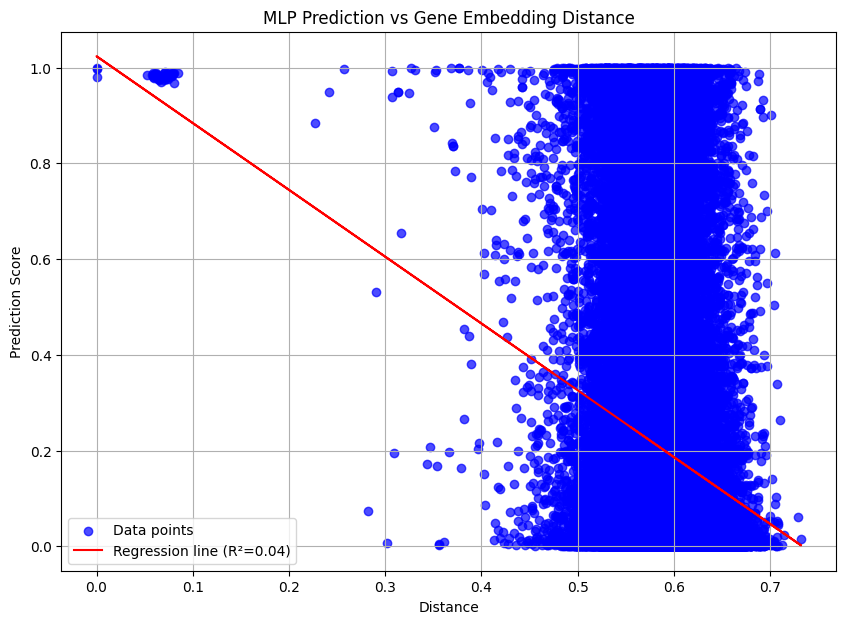

In [36]:
plot_distance_vs_prediction(euc_distances, euc_prediction_scores, 'MLP Prediction vs Gene Embedding Distance')

In [12]:
pca_distance, pca_preds, pca_pairs = PCA_Distance_vs_prediction(schizo_genes, model, embedding_dict)

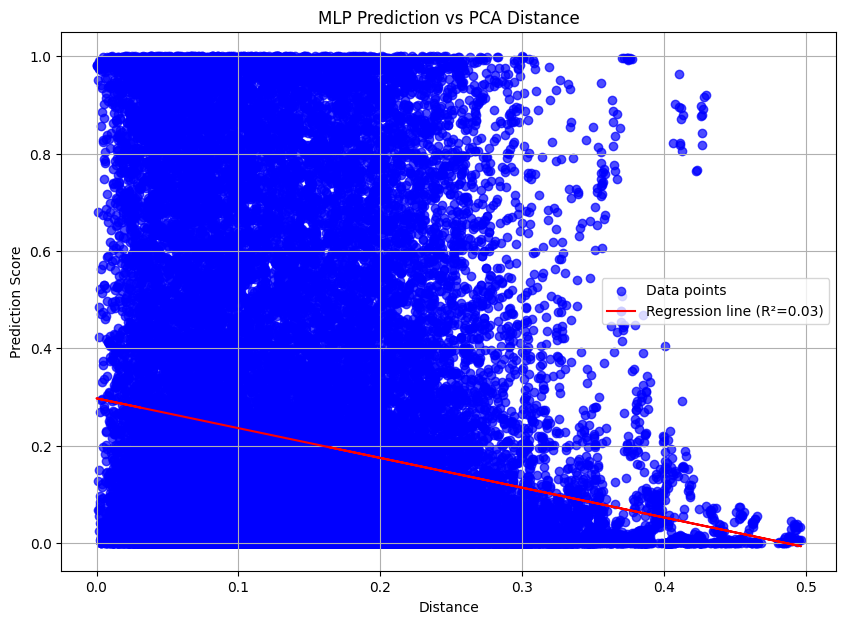

In [37]:
plot_distance_vs_prediction(pca_distance, pca_preds, 'MLP Prediction vs PCA Distance')

In [14]:
schizo_graph = load_graph("graphs/schizo_graph.gml")

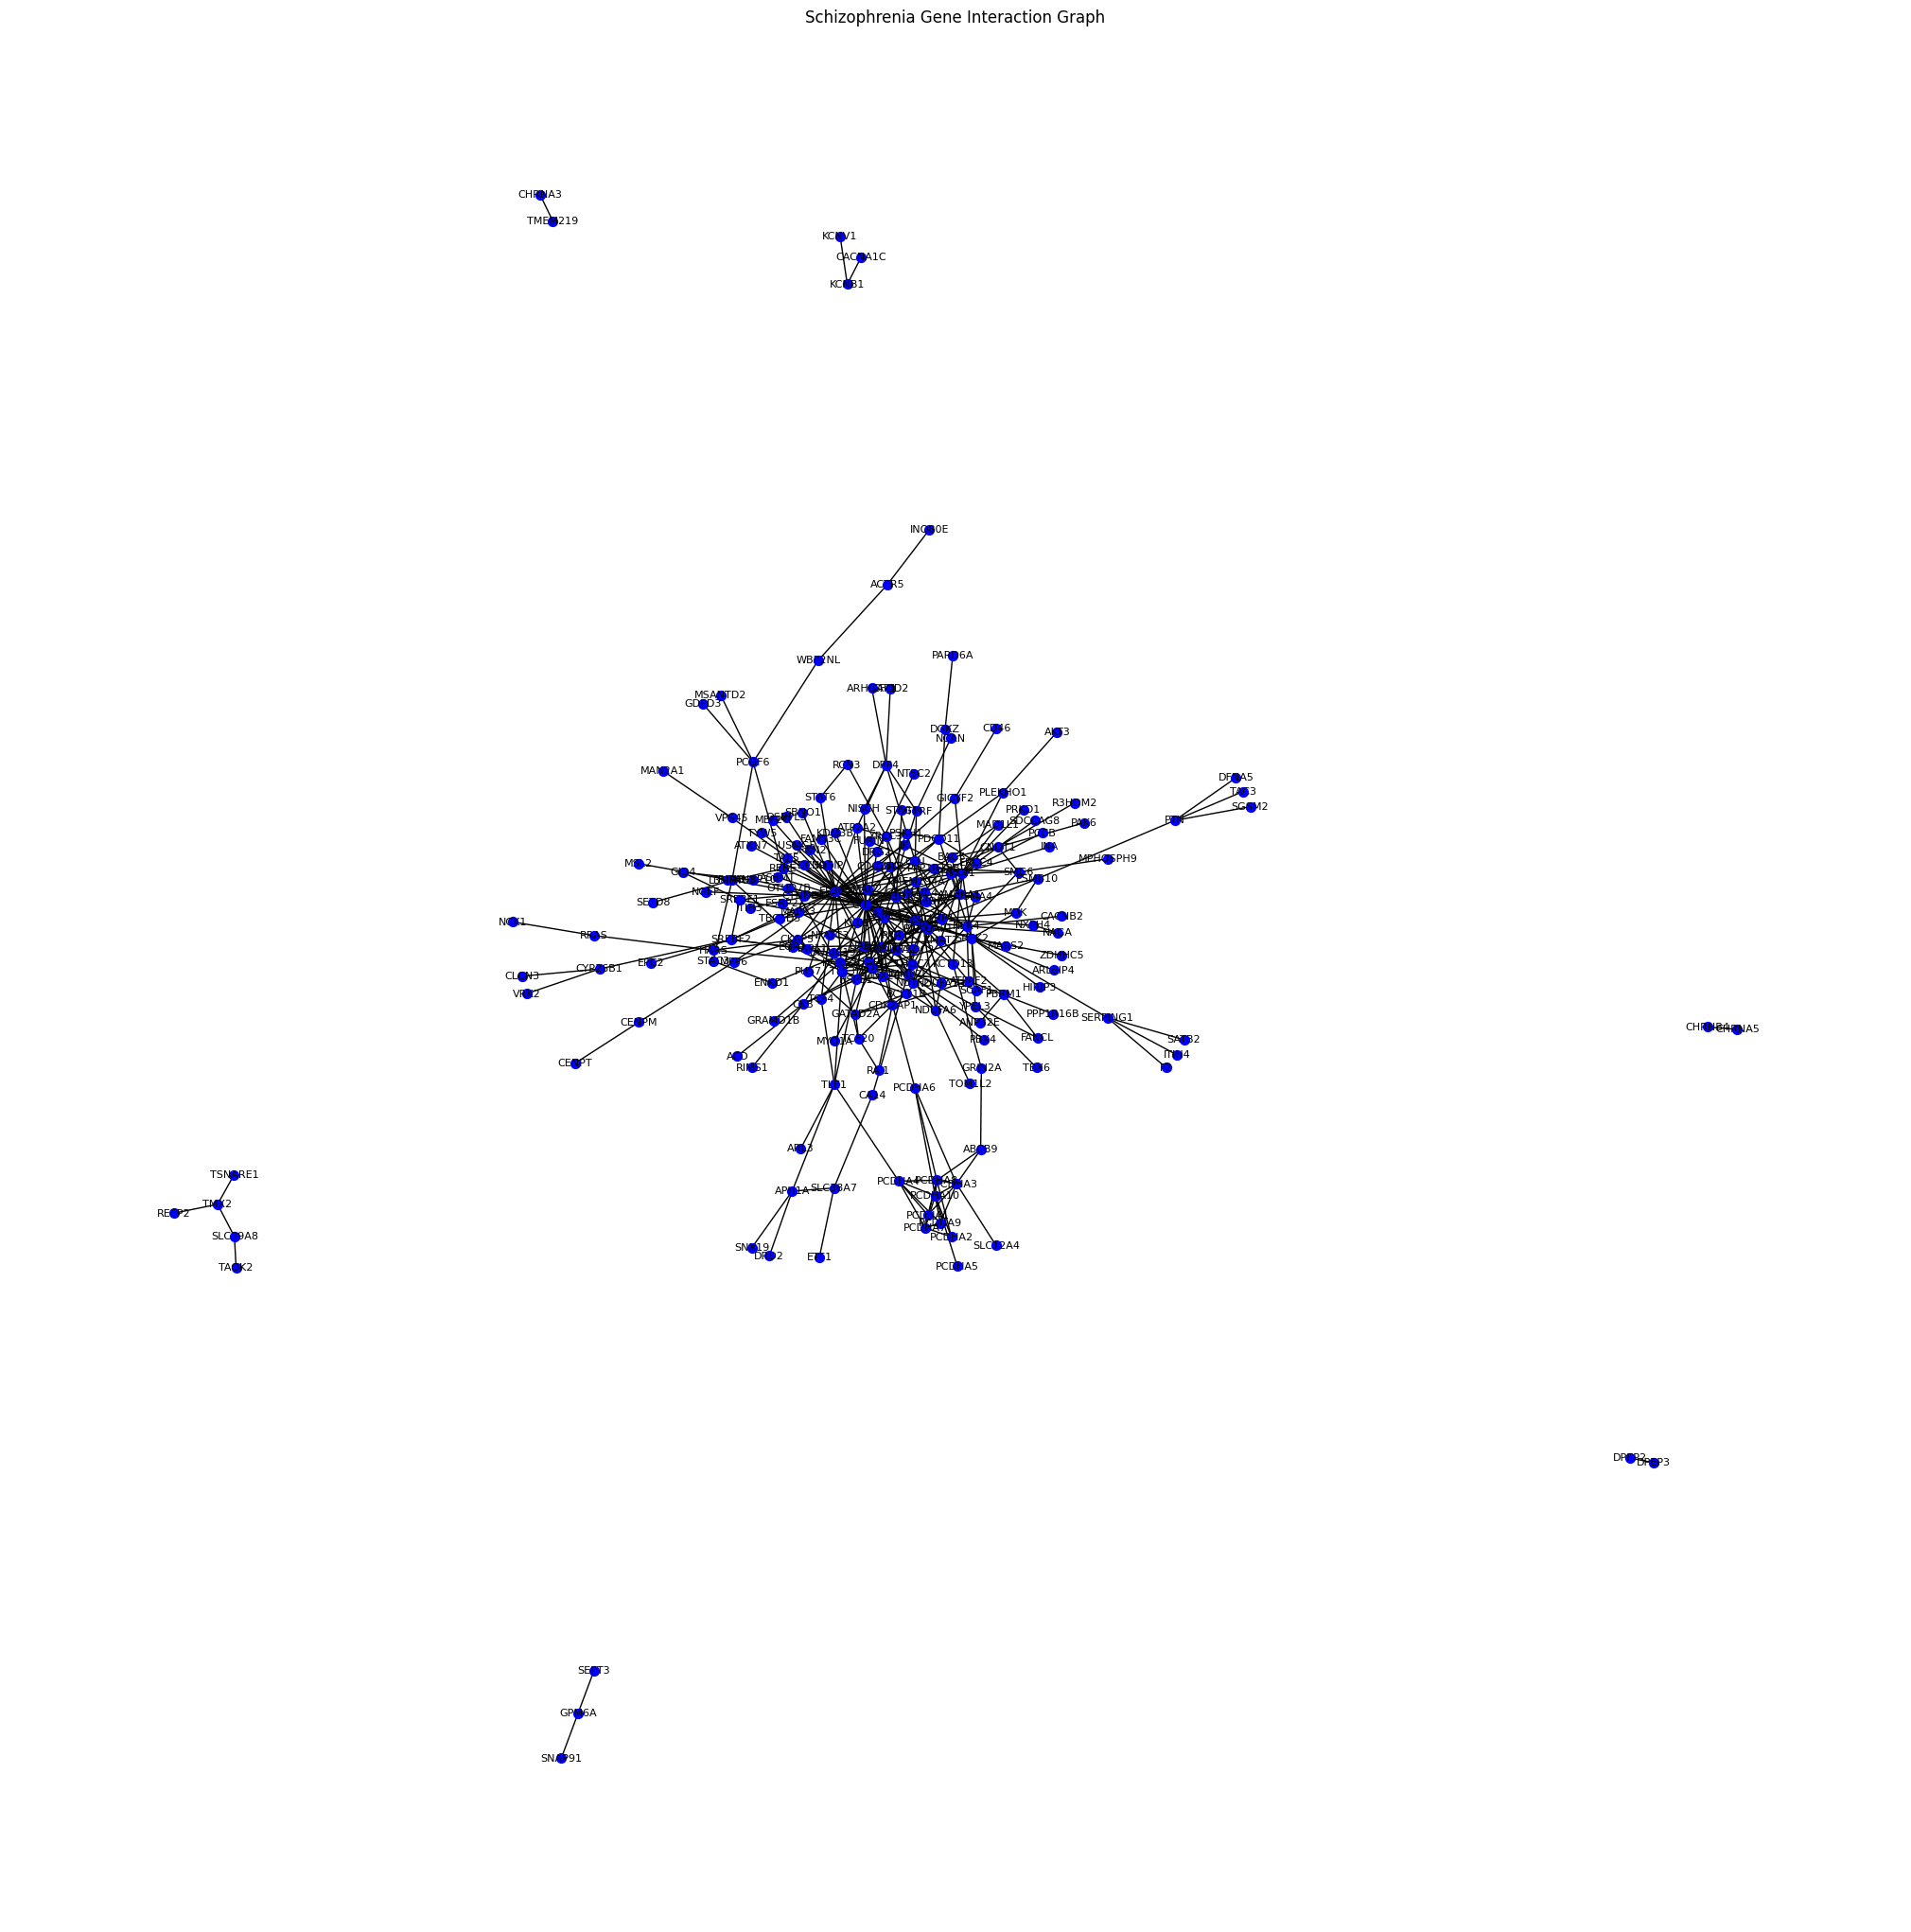

In [15]:
plot_graph(schizo_graph, title="Schizophrenia Gene Interaction Graph")

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from tqdm import tqdm

# Ensure the model and input tensors are on the same device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(device)

schizo_graph_with_preds = schizo_graph.copy()

# Assuming `existing_edges` is a list of edges already in the graph
existing_edges = set(schizo_graph.edges())
print(len(existing_edges))

# Predicted edges
predicted_edges = set()

# Filter the genes to only those present in the embedding dictionary
filtered_genes = [gene for gene in schizo_genes if gene in embedding_dict]
filtered_genes = list(set(filtered_genes))  # Remove duplicates

# Iterate over all combinations of gene pairs
with tqdm(total=len(list(combinations(filtered_genes, 2))), desc="Processing gene pairs") as pbar:
    for gene1, gene2 in combinations(filtered_genes, 2):
        prediction_score = predict_epistatic(model, gene1, gene2, embedding_dict)

        if prediction_score > 0.99:
            predicted_edges.add((gene1, gene2))
            if (gene1, gene2) not in existing_edges or (gene2, gene1) not in existing_edges:
                schizo_graph_with_preds.add_edge(gene1, gene2, weight=prediction_score, color=0)

        pbar.set_postfix({"Predicted Edges": len(predicted_edges)})
        pbar.update(1)

# Print the number of edges added
print(f"Pred: {len(predicted_edges)}")
print(f"Existing: {len(existing_edges)}")

365


Processing gene pairs: 100%|██████████| 51681/51681 [01:58<00:00, 435.91it/s, Predicted Edges=7659]


Pred: 7659
Existing: 365


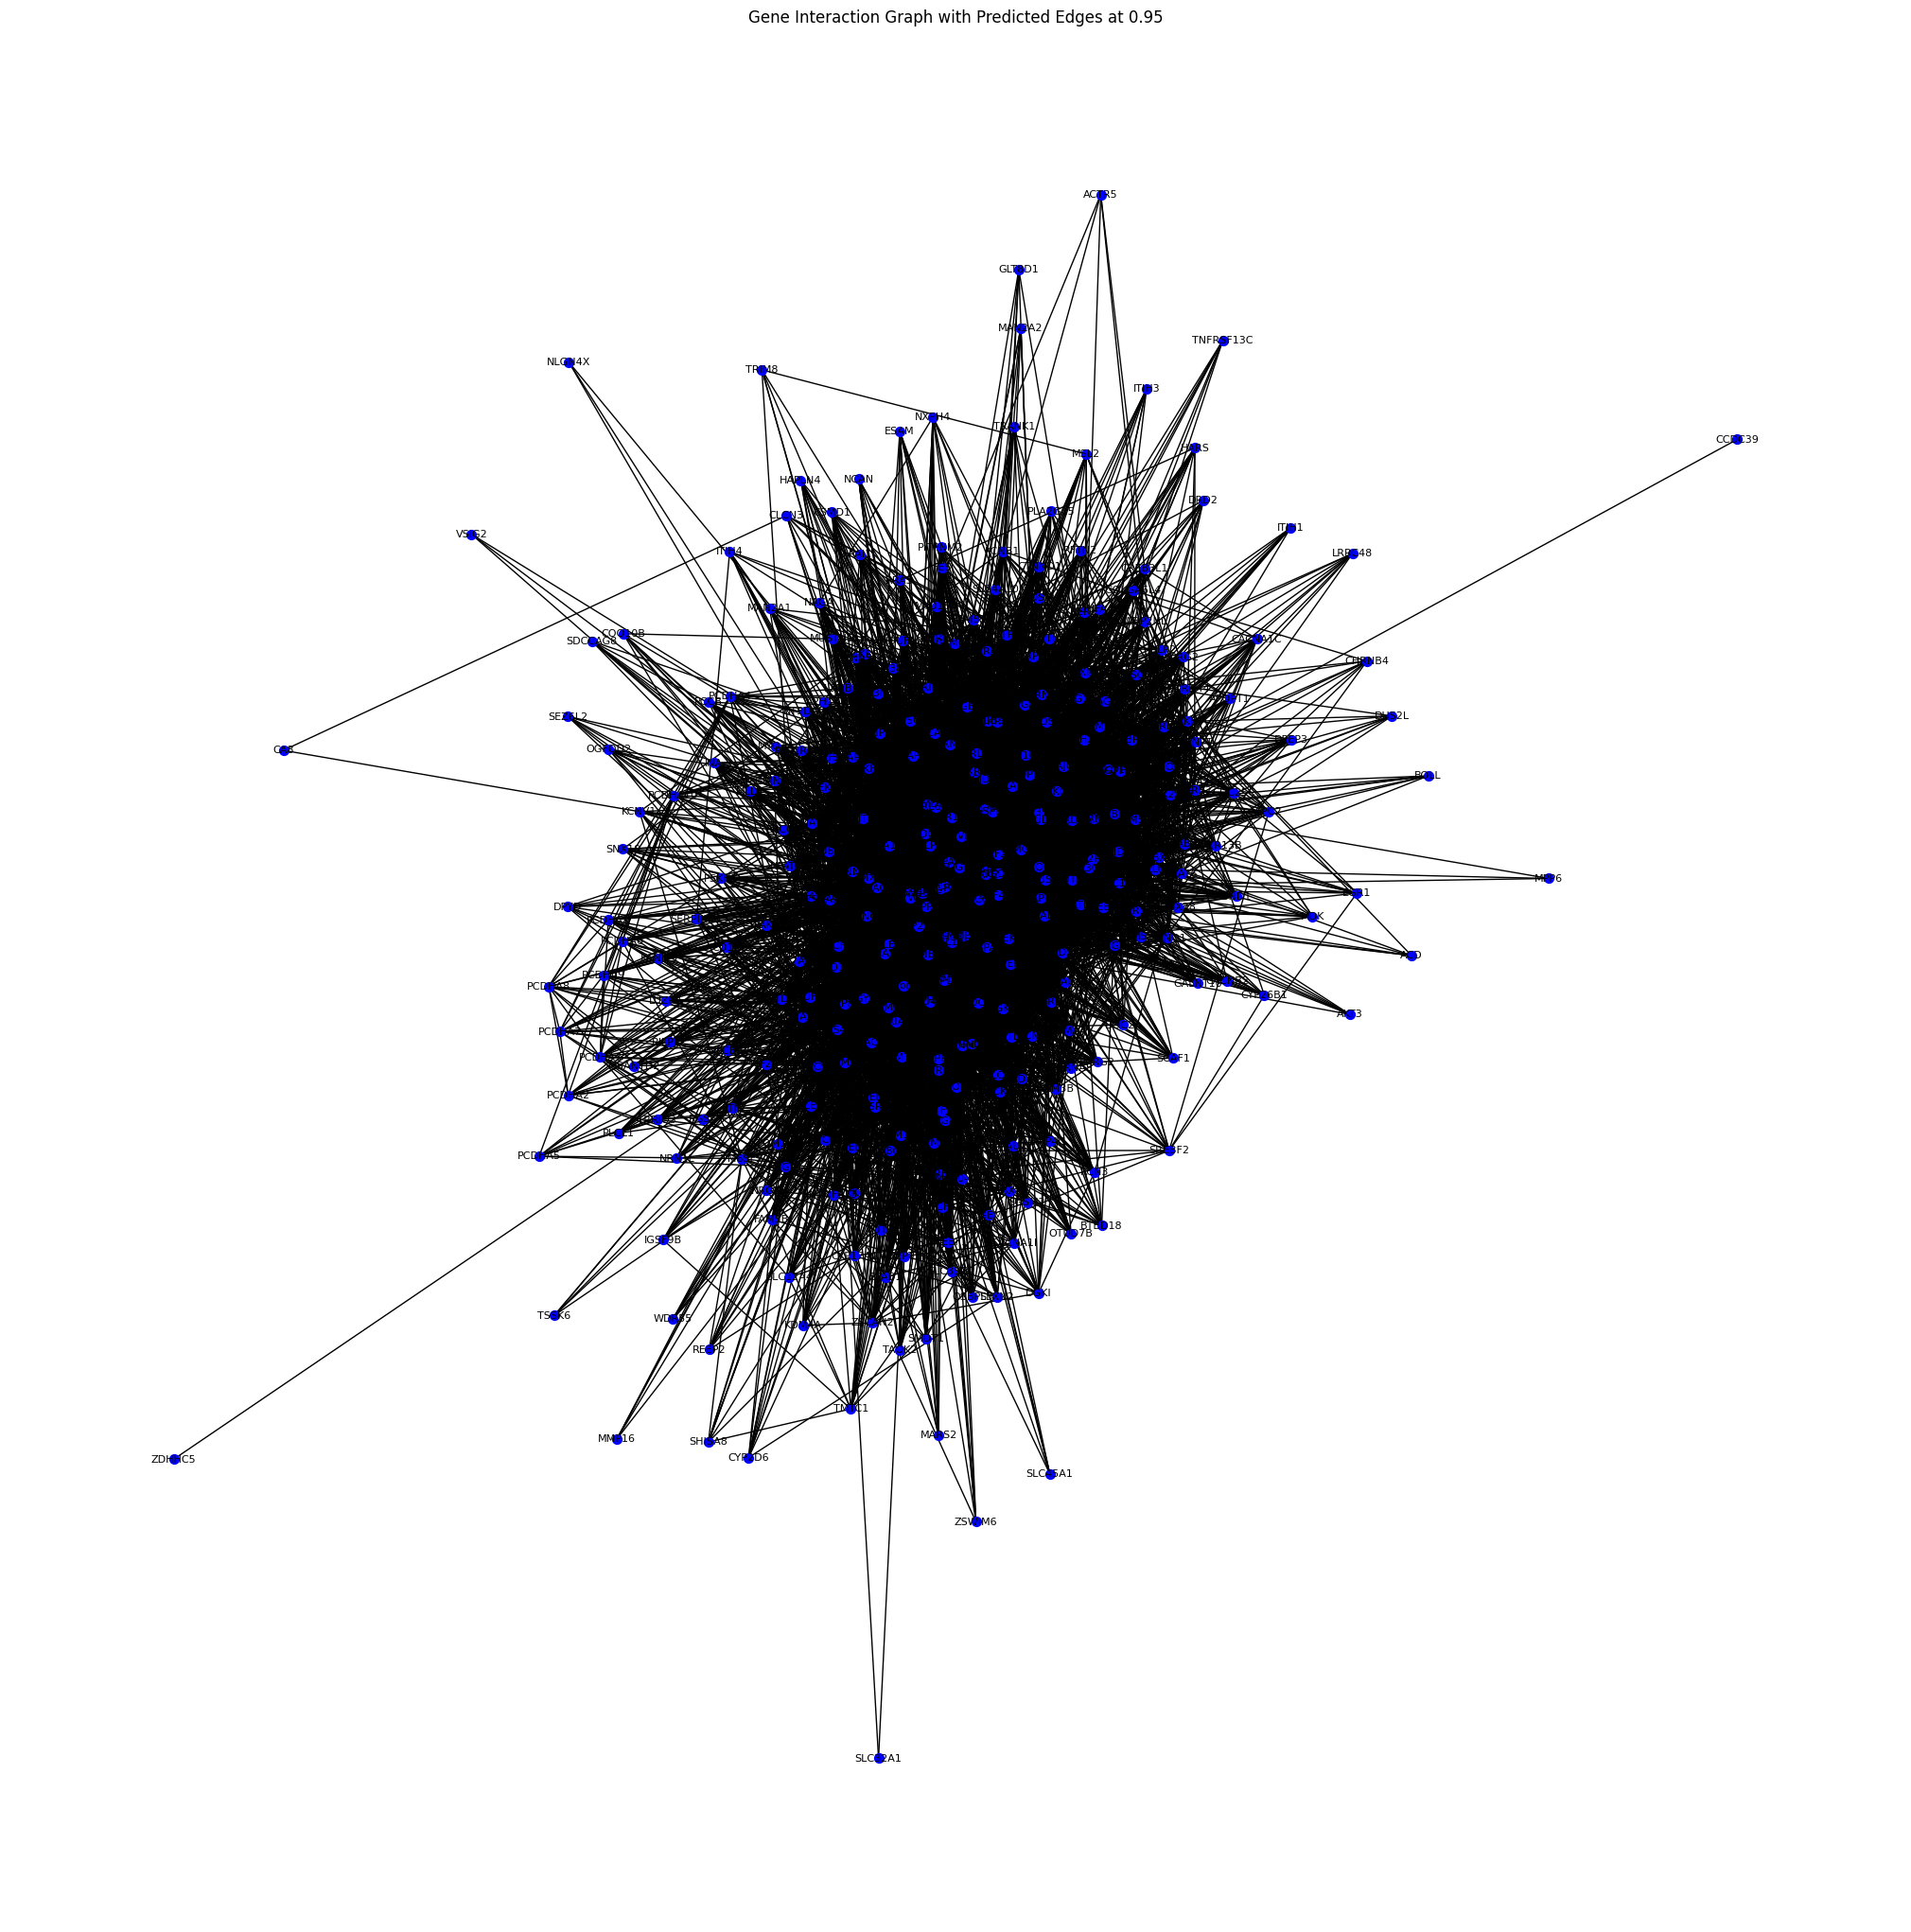

In [17]:
plot_graph(schizo_graph_with_preds, title="Gene Interaction Graph with Predicted Edges at 0.95")

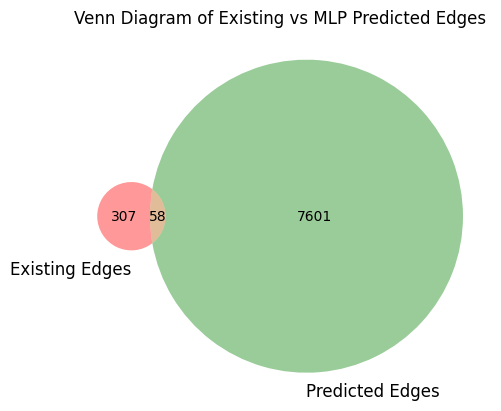

In [18]:
# Create a Venn diagram
# Add edges both directions for example if (gene1, gene2) is in existing_edges, add (gene2, gene1) too

venn2([existing_edges, predicted_edges], ('Existing Edges', 'Predicted Edges'))
plt.title("Venn Diagram of Existing vs MLP Predicted Edges")
plt.show()


In [19]:
predicted_not_in_existing = predicted_edges - existing_edges


In [20]:
predicted_not_in_existing

with open("graphs/predicted_not_in_existing_mlp.txt", "w") as f:
    for edge in predicted_not_in_existing:
        f.write(f"{edge[0]}\t{edge[1]}\n")

# Run on Sage

In [21]:
from scripts.gnn_utils import *
import torch_geometric as pyg
from torch_geometric.data import Data

In [22]:
model_constructor_args_sage = {
    'in_channels': 1536,
    'hidden_channels': 64,
    'out_channels': 16,
    'conv_type': 'SAGE' 
}
model = GraphiStasis(**model_constructor_args_sage)
model.load_state_dict(torch.load("models/SAGE.pt", map_location=torch.device('mps')))
model.to(torch.device("mps"))

GraphiStasis(
  (conv1): SAGEConv(1536, 64, aggr=mean)
  (conv2): SAGEConv(64, 16, aggr=mean)
  (bilinear): Bilinear(in1_features=16, in2_features=16, out_features=1, bias=True)
)

In [23]:
def prepare_schizo_data(graph: nx.Graph) -> Data:
    """
    Prepare the data for GNN link prediction.
    Returns a PyTorch Geometric Data object.
    """

    # Unpickle embedding dict file (read-binary mode)
    with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
        gene_embedding_dict = pickle.load(f)

    # Convert NetworkX graph to PyTorch Geometric Data object
    graph = nx.convert_node_labels_to_integers(graph)
    pyg_data = pyg.utils.from_networkx(graph)

    # Keep track of graph attributes
    node_type_list = []
    idx_to_gene = {}
    idx_to_disease = {}
    embedding_dim = len(next(iter(gene_embedding_dict.values())))
    embeddings = []
    for idx, (n, d) in enumerate(graph.nodes(data=True)):
        node_type = d.get('node_type', None) or d.get('type', None)
        node_type_list.append(node_type)
        node_name = d.get('name', str(n))
        if node_type == 1:
            idx_to_gene[idx] = node_name
            emb = gene_embedding_dict.get(node_name, np.zeros(embedding_dim))
        if node_type == 2:
            idx_to_disease[idx] = node_name
            emb = np.zeros(embedding_dim)
        embeddings.append(emb)
    print("Idx -> [Gene, Disease] mapping done")
    pyg_data.x = torch.tensor(np.stack(embeddings), dtype=torch.float32)
    print("After setting embeddings, x shape:", pyg_data.x.shape)

    # Debug prints
    try:
        print("x.shape[0]:", pyg_data.x.shape[0])
        print("edge_index.max():", pyg_data.edge_index.max())
        if pyg_data.x.shape[0] < pyg_data.edge_index.max():
            print("Warning: Edge indices reference node indices not in feature matrix.")
        else:
            print("Aight ur chillin prolly")
    except Exception as e:
        print("Error in prepare_data print statements:", e)

    if hasattr(pyg_data, 'name'): del pyg_data.name

    if not hasattr(pyg_data, 'name'): print("Name removed from pyg_data")
    print(pyg_data)

    return pyg_data, [node_type_list, idx_to_gene, idx_to_disease]


In [24]:
schizo_graph = load_graph("graphs/schizo_graph.gml")

schizo_pyg, schizo_others = prepare_schizo_data(schizo_graph)

Idx -> [Gene, Disease] mapping done
After setting embeddings, x shape: torch.Size([209, 1536])
x.shape[0]: 209
edge_index.max(): tensor(208)
Aight ur chillin prolly
Name removed from pyg_data
Data(edge_index=[2, 730], node_type=[209], num_nodes=209, x=[209, 1536])


In [25]:
selected = predict_gene_gene_links(model, schizo_pyg, schizo_others[0], schizo_others[1], save_path="figures/schizo_gene_gene_links.png")

In [26]:
filtered_selected = [(gene1, gene2, score) for gene1, gene2, score in selected if score > 0.95]
print(f"Filtered selected count: {len(filtered_selected)}")

filtered_selected = [(gene1, gene2) for gene1, gene2, _ in filtered_selected]

Filtered selected count: 839


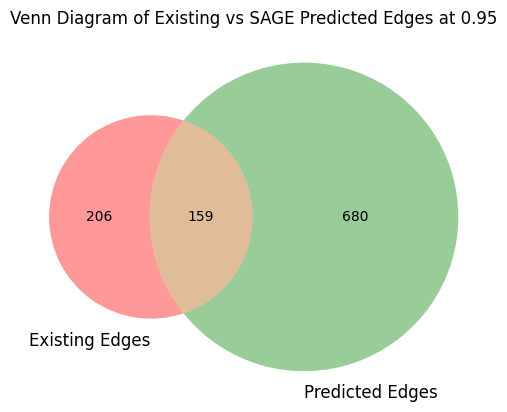

In [27]:
# Make a venn diagram of the selected edges with the existing edges
existing_edges = set(schizo_graph.edges())
predicted_edges = set(filtered_selected)

# Create a Venn diagram
venn2([existing_edges, predicted_edges], ('Existing Edges', 'Predicted Edges'))
plt.title("Venn Diagram of Existing vs SAGE Predicted Edges at 0.95")
plt.show()

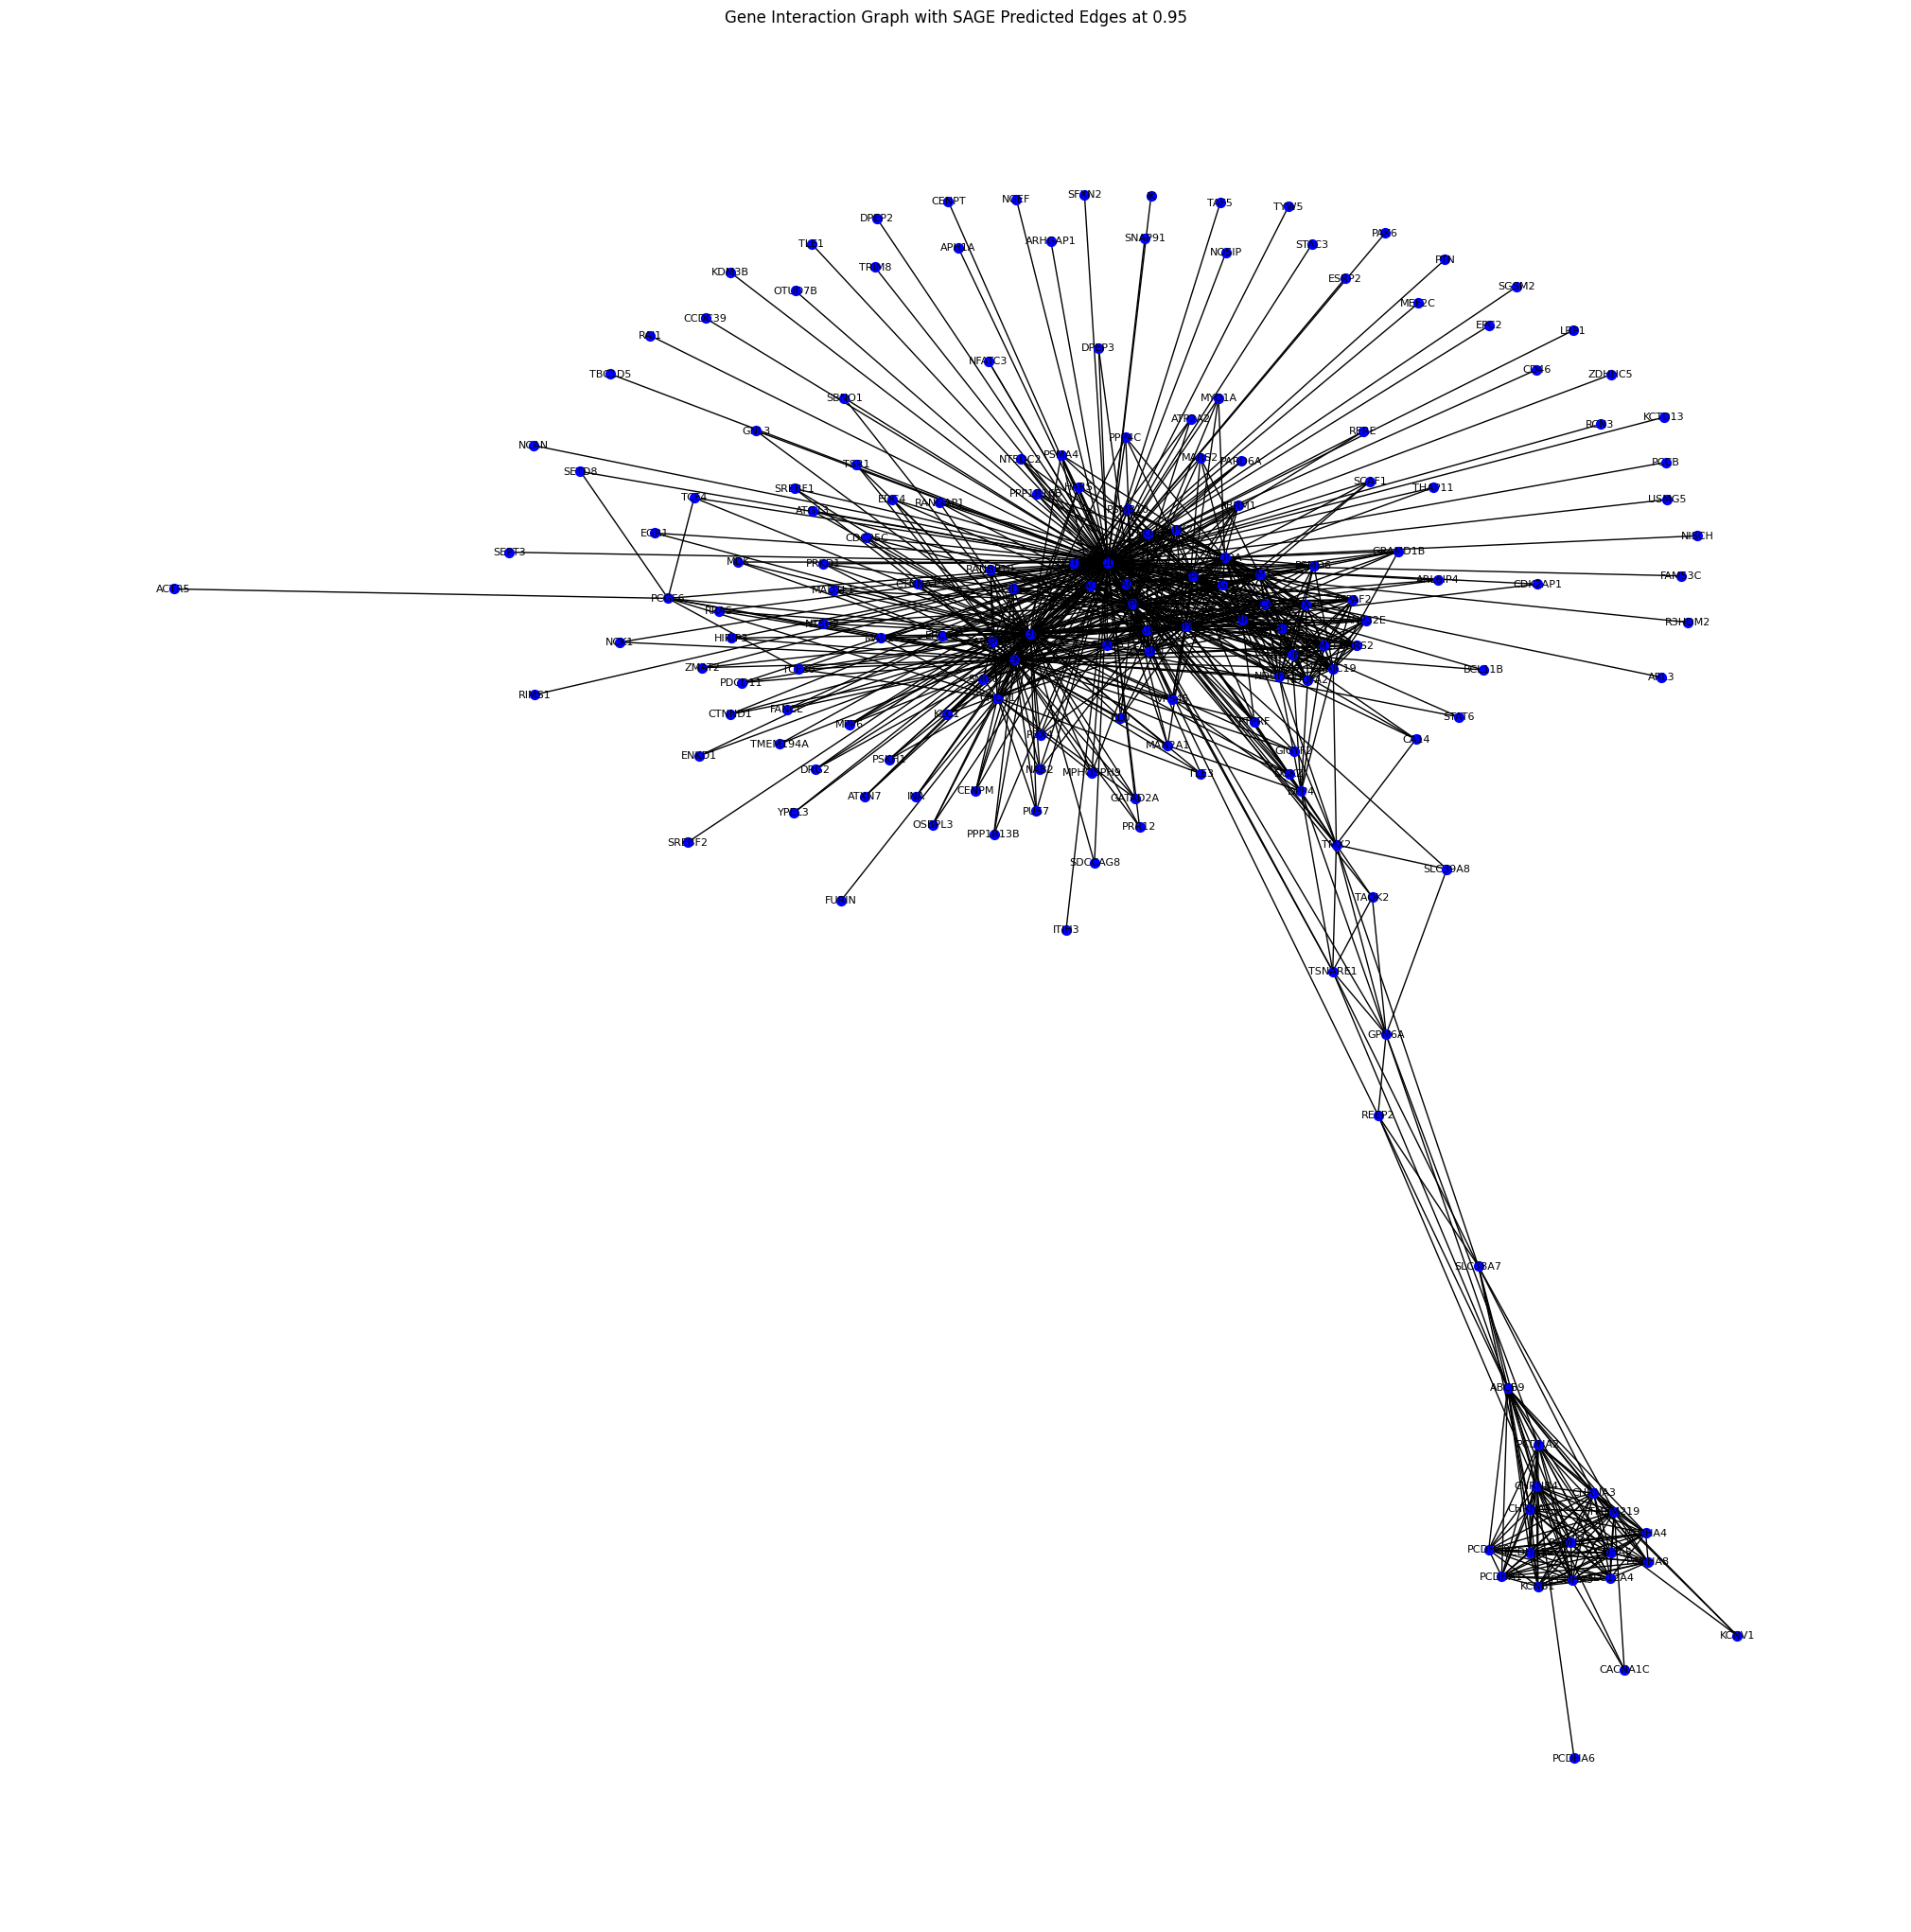

In [50]:
# Plot the graph with the predicted edges

filtered_selected # list of edges
# Make new graph from filtered selected

sage_graph = nx.Graph()
sage_graph.add_edges_from(filtered_selected)

plot_graph(sage_graph, title="Gene Interaction Graph with SAGE Predicted Edges at 0.95")

In [52]:
import random

random_50 = random.sample(filtered_selected, 50)
print(random_50)

[('HSPE1', 'PSMD6'), ('CUL3', 'STAC3'), ('CUL3', 'RAI1'), ('CUL3', 'ATP2A2'), ('HSPA9', 'CLU'), ('TAOK2', 'TSNARE1'), ('CNOT1', 'NAB2'), ('ALDOA', 'PPP4C'), ('PCDHA8', 'PCDHA9'), ('CUL3', 'NDUFA6'), ('NEK4', 'DNAJC19'), ('FXR1', 'STAG1'), ('NEK4', 'SF3B1'), ('CNOT1', 'PSKH1'), ('ALDOA', 'VPS45'), ('EP300', 'CTNND1'), ('PBRM1', 'FXR1'), ('TMX2', 'SLC39A8'), ('HSPD1', 'KLC1'), ('XRCC3', 'SUGP1'), ('NEK4', 'PARD6A'), ('HSPD1', 'SMG6'), ('CNOT1', 'GID4'), ('CNOT1', 'NUTF2'), ('HSPE1', 'ERCC4'), ('MAPK3', 'SF3B1'), ('EP300', 'PARD6A'), ('HSPA9', 'DNAJC19'), ('CUL3', 'RERE'), ('NEK4', 'MAPK3'), ('PCDHA10', 'PCDHA7'), ('IMMP2L', 'THOC7'), ('SLC38A7', 'CHRNA5'), ('HSPD1', 'GID4'), ('PSMD6', 'HSPA9'), ('CNOT1', 'MAU2'), ('HSPE1', 'PPP1R16B'), ('HSPD1', 'PSMA4'), ('NDUFA2', 'HARS2'), ('HARS2', 'NDUFA13'), ('HSPD1', 'ATP2A2'), ('PCDHA7', 'SLC12A4'), ('CUL3', 'GPM6A'), ('EP300', 'ZMAT2'), ('HSPD1', 'DPP4'), ('SRPK2', 'NUTF2'), ('GPM6A', 'PCDHA2'), ('BAG5', 'PBRM1'), ('HSPD1', 'BAG5'), ('DPP4', 'GP

In [29]:
# Return score and embedding distance

def euclidean_distance_vs_predictions_GNN(results, embedding_dict):
    distances = []
    prediction_scores = []

    for (gene1, gene2, score) in results:
        
        if gene1 not in embedding_dict or gene2 not in embedding_dict:
            continue
        
        # Get the embeddings for the two genes
        gene1_embedding = embedding_dict[gene1]
        gene2_embedding = embedding_dict[gene2]

        # Calculate the Euclidean distance between the two genes
        distance = np.linalg.norm(np.array(gene1_embedding) - np.array(gene2_embedding))

        # Store the results
        distances.append(distance)
        prediction_scores.append(score)

    return distances, prediction_scores

In [46]:
SAGE_euc_distances, SAGE_euc_prediction_scores = euclidean_distance_vs_predictions_GNN(selected, embedding_dict)

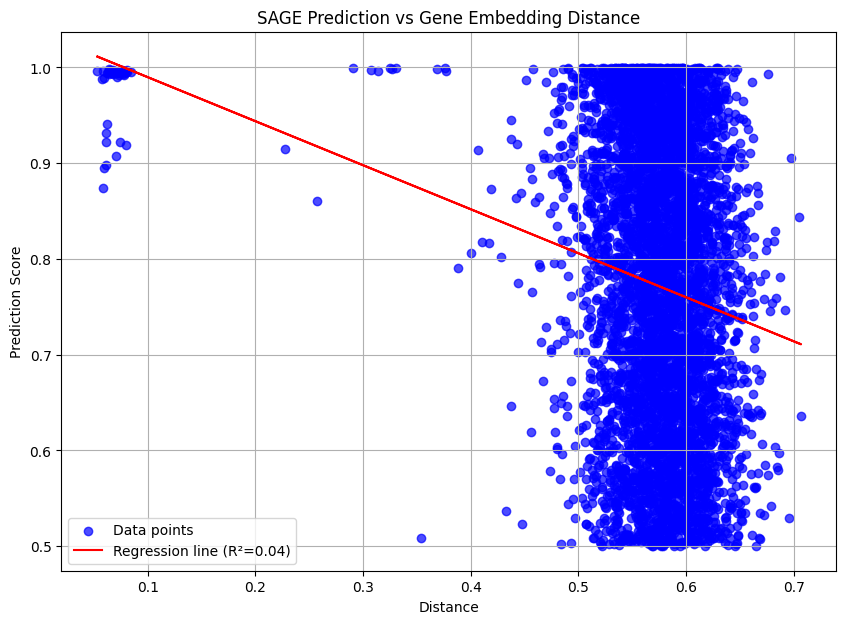

In [47]:
plot_distance_vs_prediction(SAGE_euc_distances, SAGE_euc_prediction_scores, 'SAGE Prediction vs Gene Embedding Distance')

In [40]:
# PCA vs prediction

def PCA_Distance_vs_prediction_GNN(results, embedding_dict):
    filtered_genes = set()
    for (gene1, gene2, score) in results:
        filtered_genes.add(gene1)
        filtered_genes.add(gene2)

    filtered_genes = [gene for gene in filtered_genes if gene in embedding_dict]
    embeddings_matrix = np.array([embedding_dict[gene] for gene in filtered_genes])
    pca = PCA(n_components=2)  # Reduce to 2 principal components
    principal_components = pca.fit_transform(embeddings_matrix)

    distances = []
    prediction_scores = []
    gene_pairs = []

    # Iterate over all gene pairs in results
    for (gene1, gene2, score) in results:
        if gene1 in embedding_dict and gene2 in embedding_dict:
            if gene1 != gene2:
                # Get the PCA coordinates of the two genes
                gene1_pca = principal_components[filtered_genes.index(gene1)]
                gene2_pca = principal_components[filtered_genes.index(gene2)]

                # Calculate the Euclidean distance between the two genes in PCA space
                distance = euclidean(gene1_pca, gene2_pca)

                # Store the results
                distances.append(distance)
                prediction_scores.append(score)
                gene_pairs.append((gene1, gene2))

    return distances, prediction_scores, gene_pairs

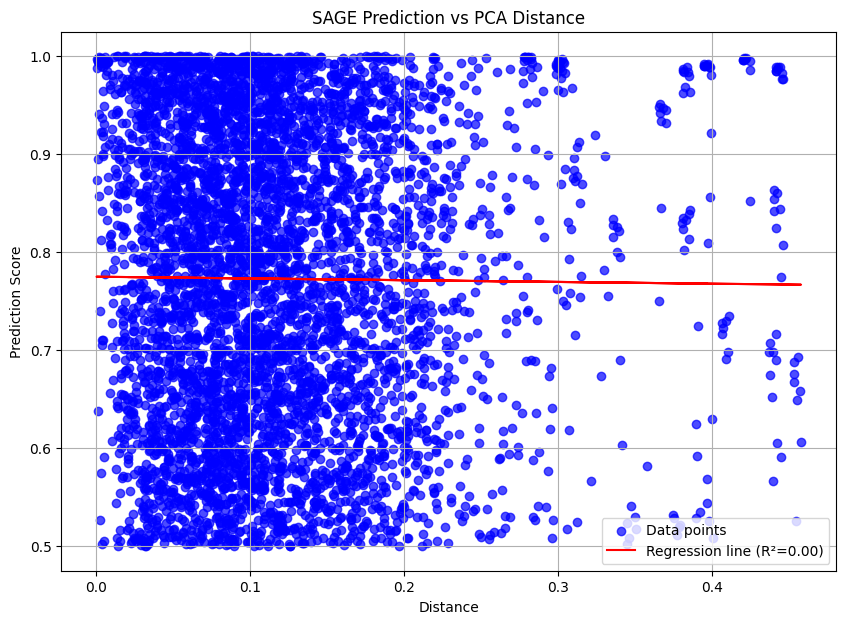

In [48]:
SAGE_PCA_distances, SAGE_PCA_prediction_scores, __ = PCA_Distance_vs_prediction_GNN(selected, embedding_dict)
plot_distance_vs_prediction(SAGE_PCA_distances, SAGE_PCA_prediction_scores, 'SAGE Prediction vs PCA Distance')